Corresponding to the main text section on DiT representation analsys

In [1]:
import torch 
import torch as th 
import torch.nn as nn
import os
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from stats_plot_utils import saveallforms, add_rectangles

### Prep training data

In [3]:
# train_data_fn = "train_inputs_new.pt"
# train_attrs = torch.load(f'/n/home12/binxuwang/Github/DiffusionReasoning/{train_data_fn}')
# train_attrs = train_attrs.to(int)
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [4]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_rules = heldout_id_dict["train_inputs_new.pt"]


### Experiment sweeping

In [5]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch:07d}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [6]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"

In [10]:
!basename {exproot}/098*

098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050


In [11]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"098-RAVEN10_abstract-uncond-DiT_S_1-stream0_016M_heldout0_20240816-0050"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=True)
figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]

In [12]:
syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis_EMA.csv"), index=False)
syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis_EMA.csv"), index=False)

In [13]:
# find max and which row
print("Best classification result: ")
syn_df_DiT.loc[syn_df_DiT['Test Accuracy'].idxmax()]

Best classification result: 


Layer             blocks.11
Test Accuracy      0.928625
Train Accuracy      0.95785
t                      50.0
epoch                100000
dimred             avgtoken
Name: 309, dtype: object

In [14]:
# find max and which row
print("Top 5 classification result: ")
syn_df_DiT.loc[ syn_df_DiT['Test Accuracy'].nlargest(10).index ]

Top 5 classification result: 


Layer  Test Accuracy  Train Accuracy      t   epoch    dimred
309  blocks.11       0.928625        0.957850   50.0  100000  avgtoken
308   blocks.8       0.923950        0.951292   50.0  100000  avgtoken
379  blocks.11       0.917600        0.948417  100.0  100000  avgtoken
239  blocks.11       0.906125        0.941033   25.0  100000  avgtoken
378   blocks.8       0.905875        0.939342  100.0  100000  avgtoken
238   blocks.8       0.903150        0.934683   25.0  100000  avgtoken
249  blocks.11       0.900050        0.941117   25.0  200000  avgtoken
304  blocks.11       0.886225        0.926958   50.0  100000    pca384
248   blocks.8       0.885200        0.928183   25.0  200000  avgtoken
374  blocks.11       0.884150        0.925608  100.0  100000    pca384

In [15]:
# find max and which row
print("Best classification result: ")
# find Layer == 'blocks.11' t== 25.0 epoch == 1000000
syn_df_DiT.loc[ (syn_df_DiT['Layer'] == 'blocks.11') & 
                (syn_df_DiT['t'] == 25.0) & 
                (syn_df_DiT['epoch'] == 1000000) ]

Best classification result: 


Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
274  blocks.11       0.602700        0.648142  25.0  1000000    pca384
279  blocks.11       0.609225        0.656800  25.0  1000000  avgtoken

### Scaling with diffusion time

#### early in training

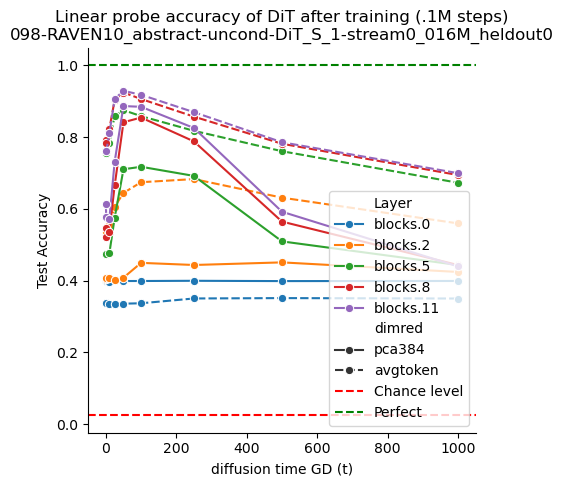

In [22]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[syn_df_DiT.epoch==100000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_alldimred_EMA", figh)

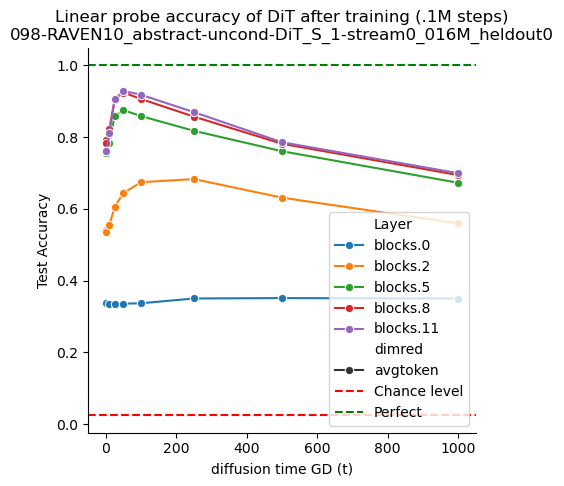

In [23]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==100000) & (syn_df_DiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_avgtoken_EMA", figh)

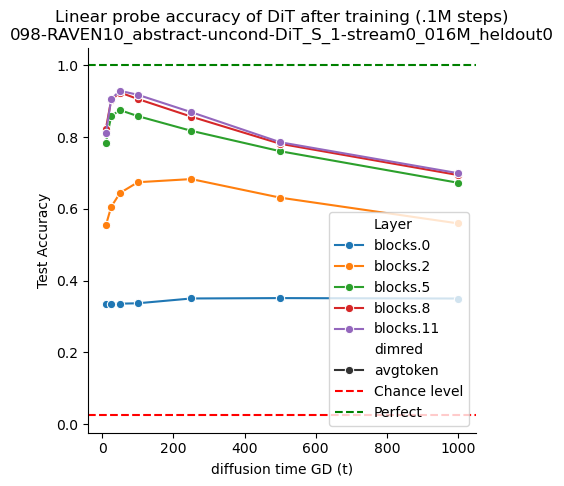

In [24]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==100000) & (syn_df_DiT.dimred=="avgtoken") & (syn_df_DiT.t > 1)], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_avgtoken_EMA_clip1", figh)

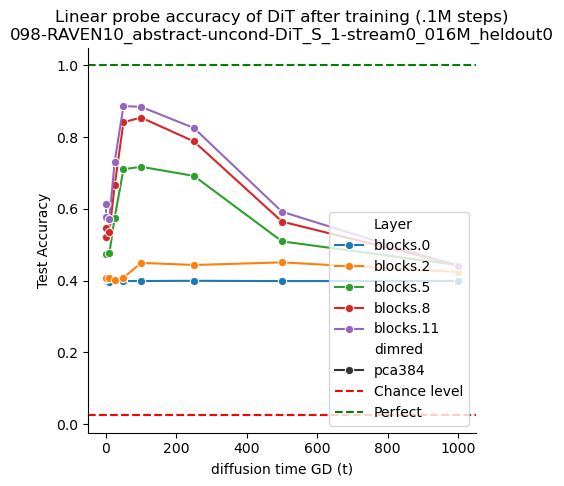

In [25]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==100000) & (syn_df_DiT.dimred=="pca384")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (.1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{100000}_pca384_EMA", figh)

#### After training

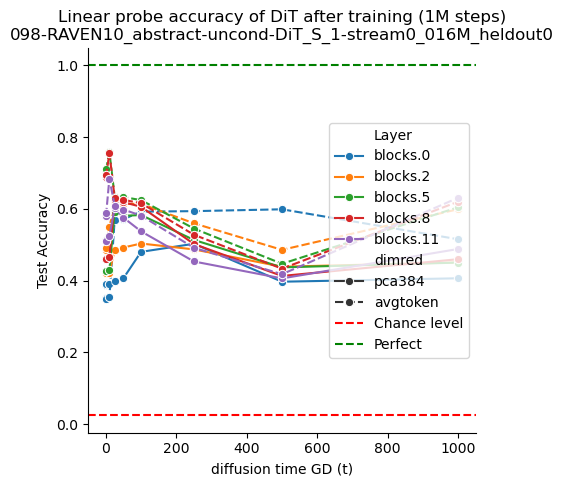

In [16]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[syn_df_DiT.epoch==1000000], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='best')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_alldimred_EMA", figh)

The first two dots were t=0 and t=1 which maybe weird due to lack of training? / too close to the clean image 

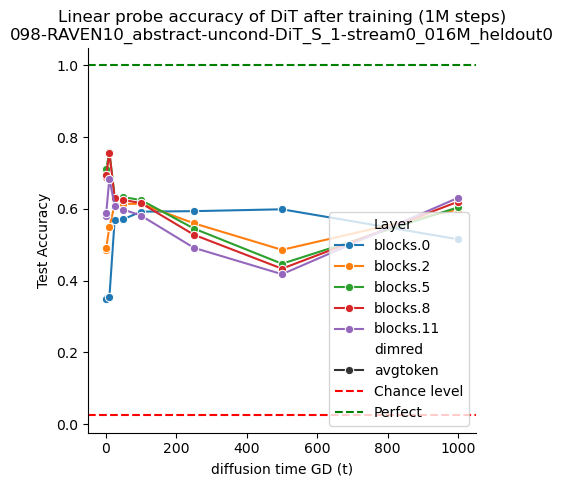

In [17]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==1000000) & (syn_df_DiT.dimred=="avgtoken")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA", figh)

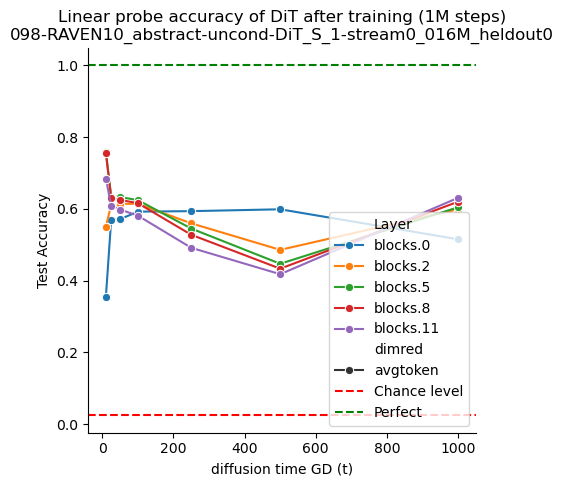

In [18]:
# syn_df_DiT.plot(x="t", y="Test Accuracy", hue="Layer", marker="o") # style=, 
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==1000000) & (syn_df_DiT.dimred=="avgtoken") & (syn_df_DiT.t > 1)], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_avgtoken_EMA_clip1", figh)

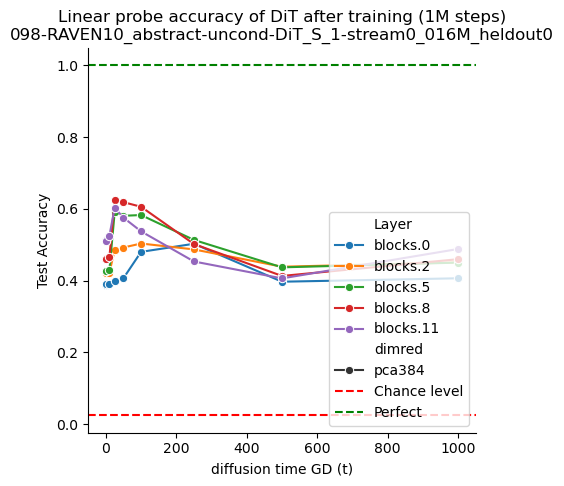

In [19]:
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.epoch==1000000) & (syn_df_DiT.dimred=="pca384")], 
             x="t", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("diffusion time GD (t)")
plt.title(f"Linear probe accuracy of DiT after training (1M steps)\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_difftime+Layer_step{1000000}_pca384_EMA", figh)

### Scaling with training time

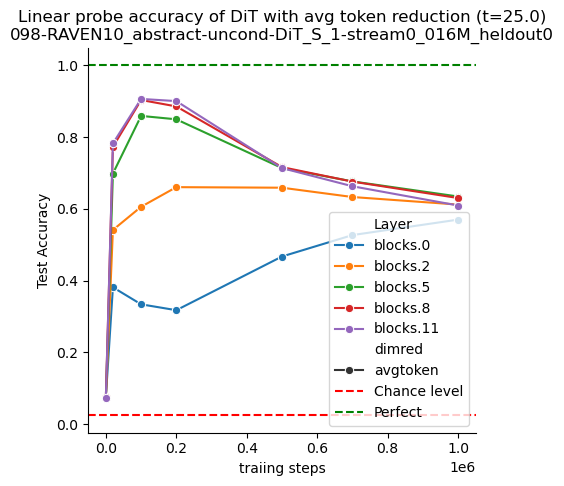

In [26]:
t_scalar = 25.0
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="avgtoken")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of DiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_avgtoken_EMA", figh)
plt.show()

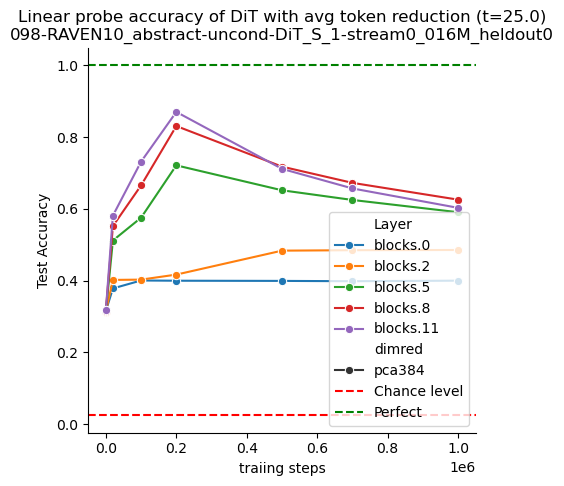

In [27]:
t_scalar = 25.0
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="pca384")], 
             x="epoch", y="Test Accuracy", hue="Layer", marker="o", style="dimred")
plt.xlabel("traiing steps")
plt.title(f"Linear probe accuracy of DiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_train_step+Layer_t{t_scalar}_pca384_EMA", figh)
plt.show()

### Scaling with layer depth

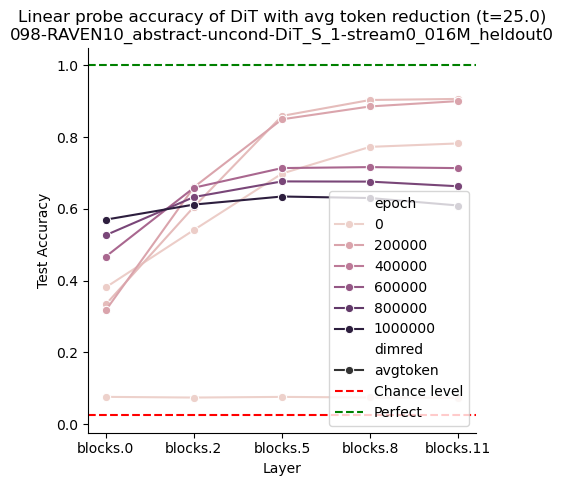

In [28]:
t_scalar = 25.0
figh = plt.figure(figsize=(5, 5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="avgtoken")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of DiT with avg token reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
plt.legend(loc='lower right')
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_avgtoken_EMA", figh)

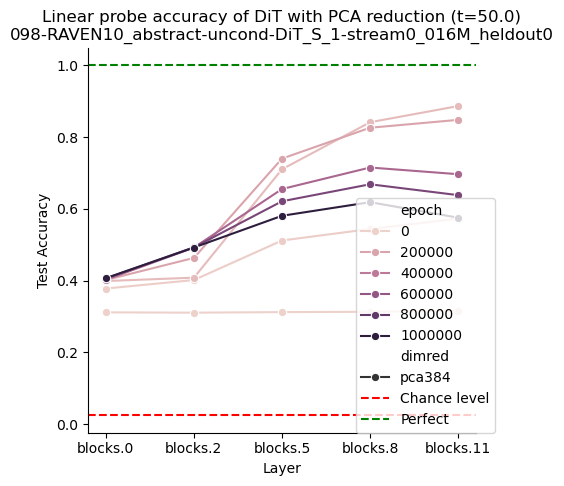

In [29]:
t_scalar = 50.0
figh = plt.figure(figsize=(5,5))
sns.lineplot(data=syn_df_DiT[(syn_df_DiT.t==t_scalar) & (syn_df_DiT.dimred=="pca384")], 
             x="Layer", y="Test Accuracy", hue="epoch", marker="o", style="dimred")
plt.xlabel("Layer")
plt.title(f"Linear probe accuracy of DiT with PCA reduction (t={t_scalar})\n{expname_short}")
plt.axhline(1/40, color='r', linestyle='--', label="Chance level")
plt.axhline(1.0, color='g', linestyle='--', label="Perfect")
# put legend outside
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 0.0), borderaxespad=0.)
saveallforms(figexpdir, f"acc_curve_Layer+train_step_t{t_scalar}_pca384_EMA", figh)

### Error splitting plot 

In [30]:
from rule_new_utils import attribute_dict, relation_dict
from sklearn.metrics import confusion_matrix
def visualize_cm(cm, heldout_rules, titlestr=""):
    figh1 = plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
    plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh2, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    return figh1, figh2
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

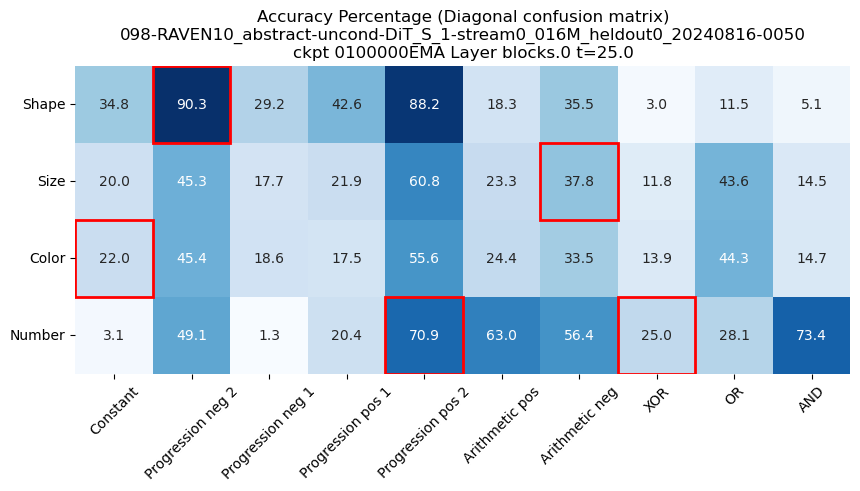

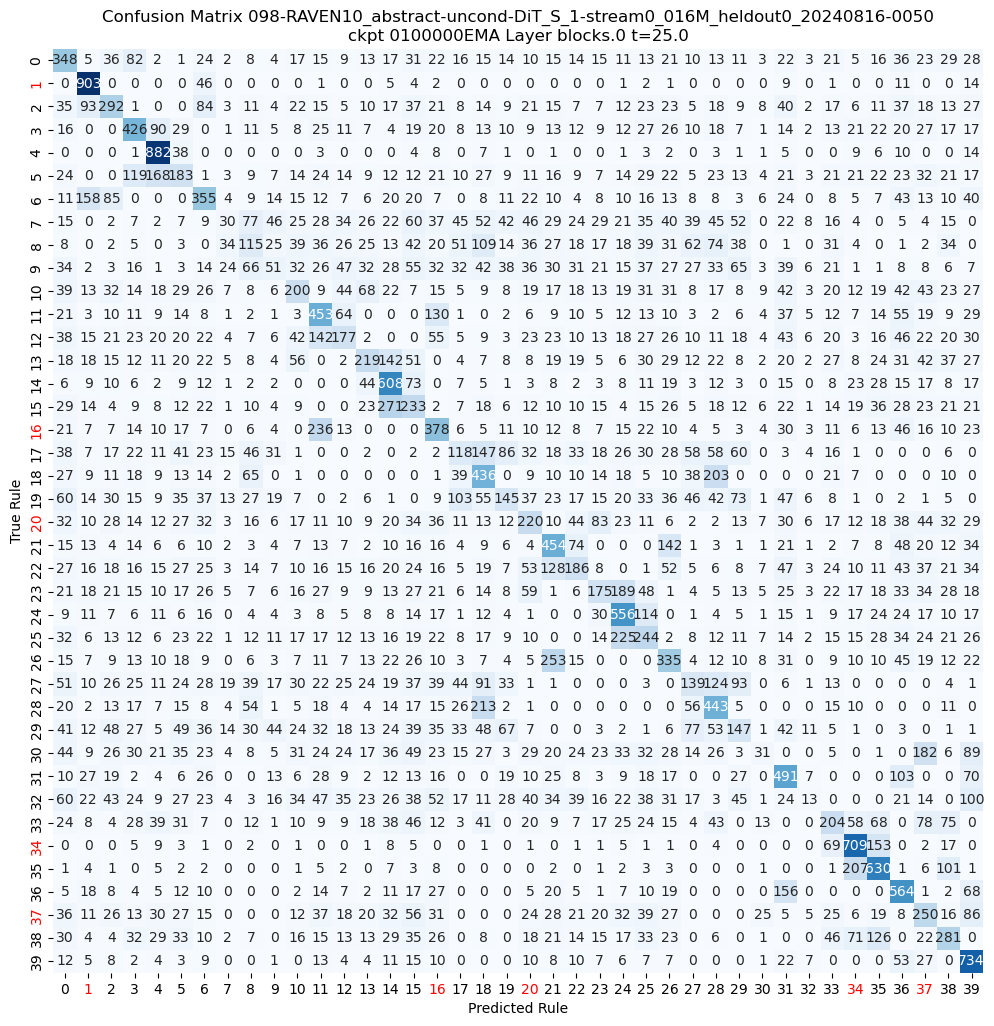

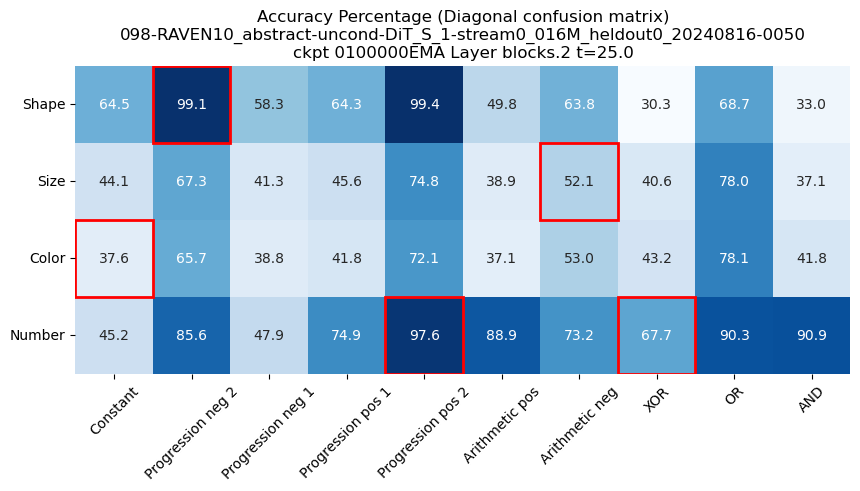

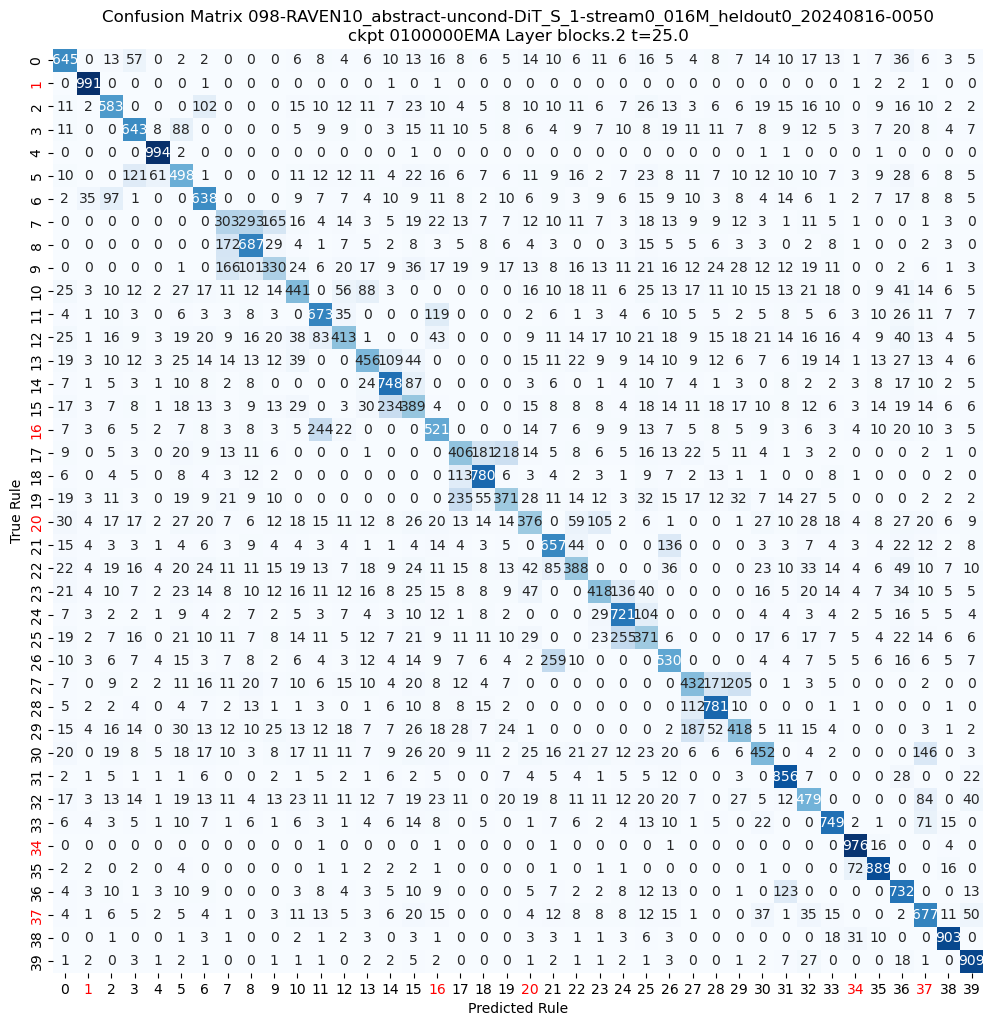

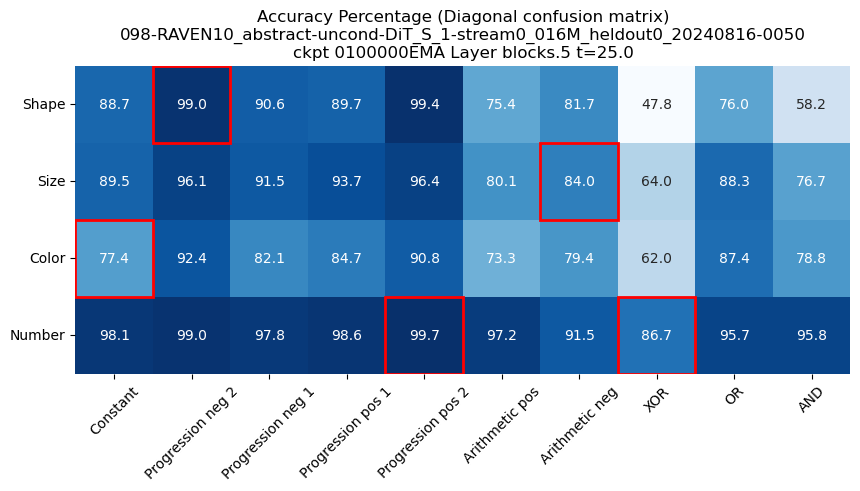

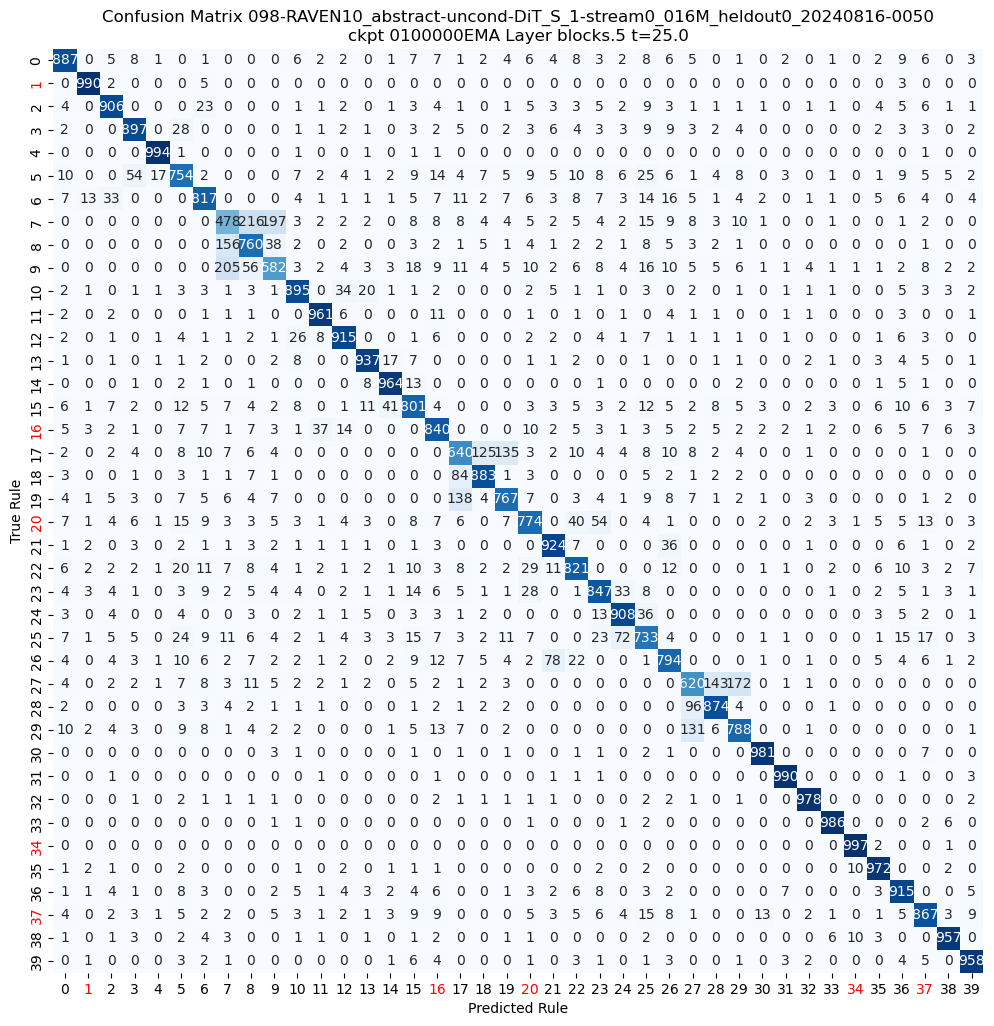

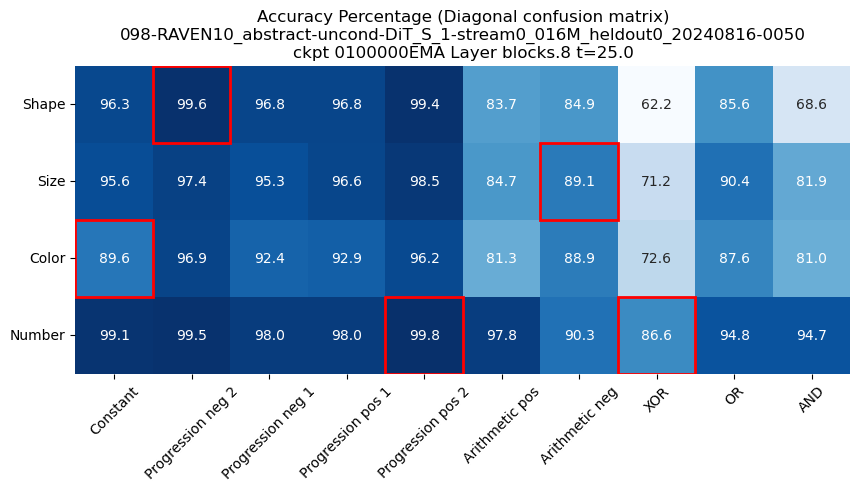

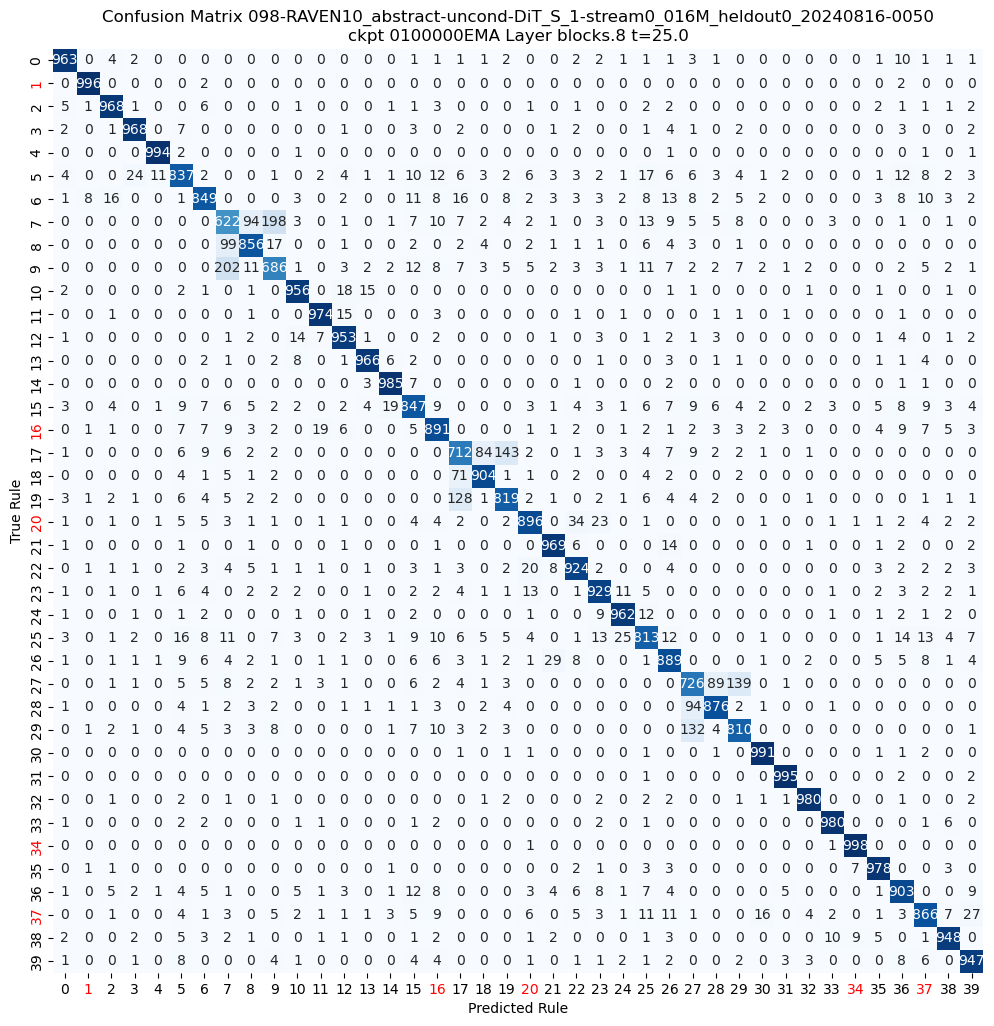

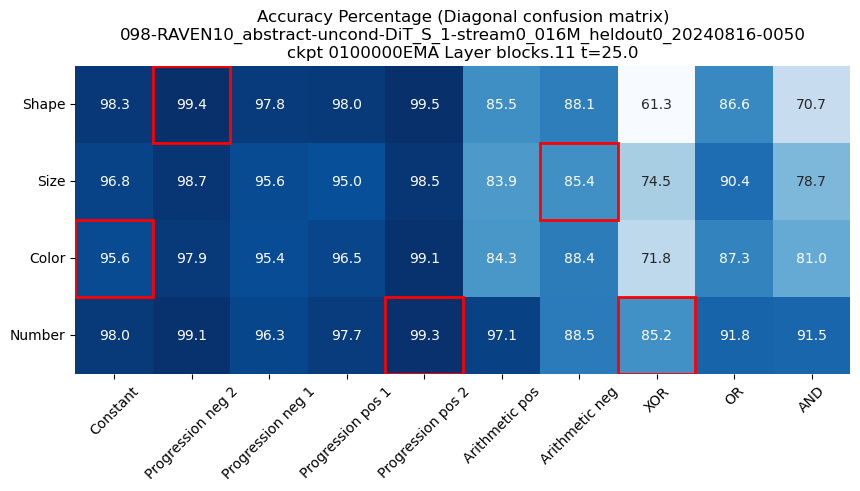

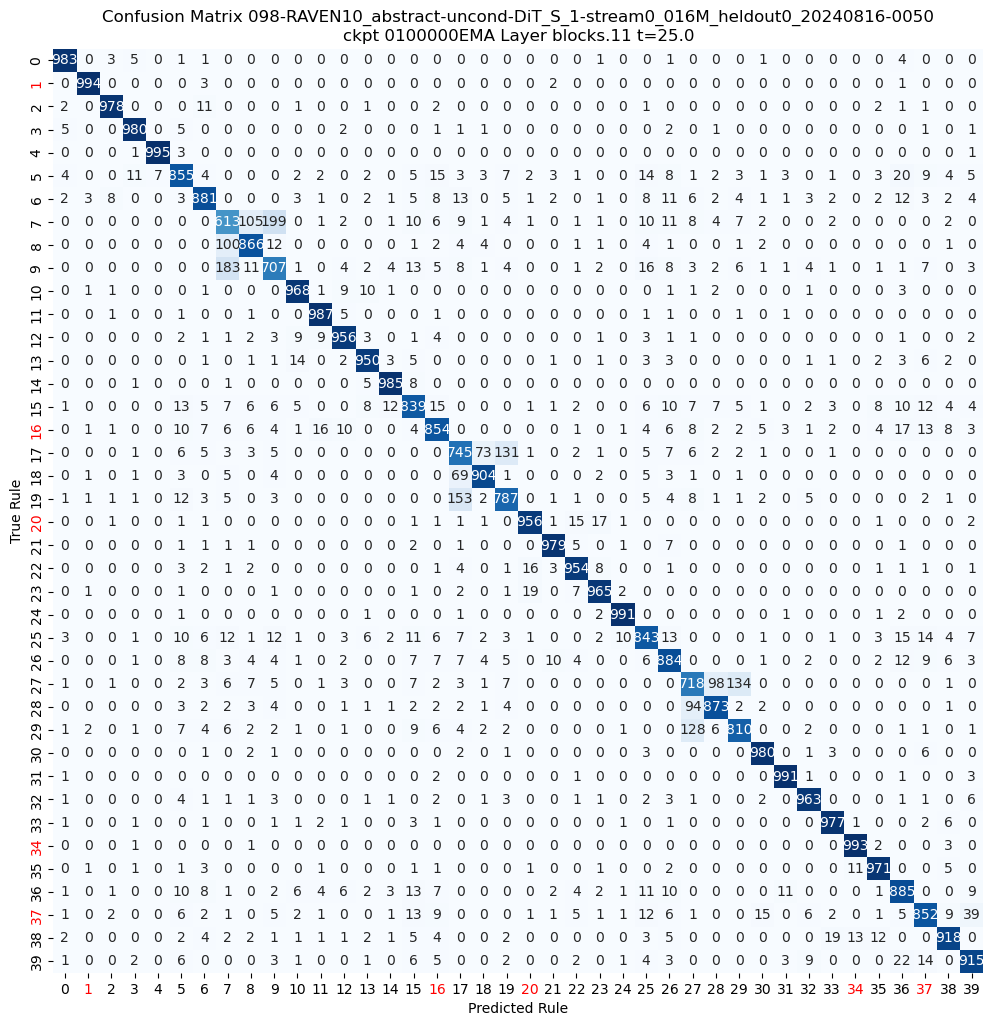

In [39]:
syn_df_all = []
epoch = 100000
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt{epoch:07d}EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        fig1, fig2 = visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"{expname}\nckpt {epoch:07d}EMA Layer {layer} t={t_scalar}")
        saveallforms(figexpdir, f"acc_per_rule_{layer}_t{t_scalar}_ckpt{epoch:07d}EMA", fig1)
        saveallforms(figexpdir, f"rule_confmat_{layer}_t{t_scalar}_ckpt{epoch:07d}EMA", fig2)

In [40]:
syn_df_DiT

Layer  Test Accuracy  Train Accuracy       t    epoch    dimred
0     blocks.0       0.313050        0.359283     0.0       -1    pca384
1     blocks.2       0.315175        0.357608     0.0       -1    pca384
2     blocks.5       0.315400        0.358650     0.0       -1    pca384
3     blocks.8       0.312875        0.357142     0.0       -1    pca384
4    blocks.11       0.317900        0.358925     0.0       -1    pca384
..         ...            ...             ...     ...      ...       ...
625   blocks.0       0.515125        0.523667  1000.0  1000000  avgtoken
626   blocks.2       0.598900        0.640617  1000.0  1000000  avgtoken
627   blocks.5       0.604325        0.643458  1000.0  1000000  avgtoken
628   blocks.8       0.619900        0.657883  1000.0  1000000  avgtoken
629  blocks.11       0.630675        0.664417  1000.0  1000000  avgtoken

[630 rows x 6 columns]

### Rule splitting plot

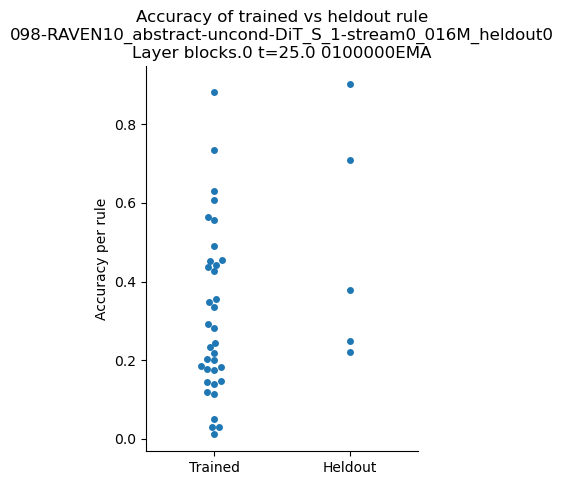

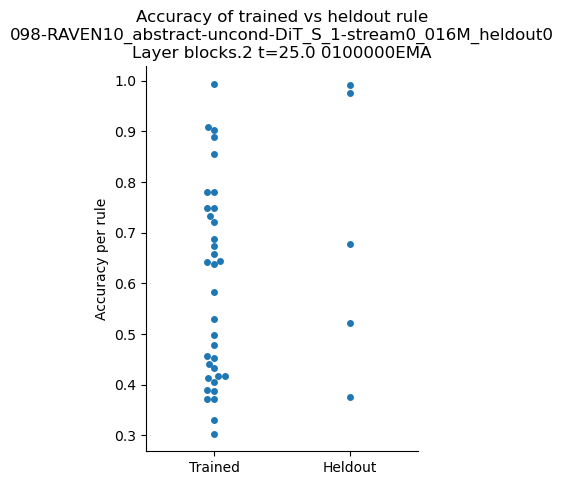

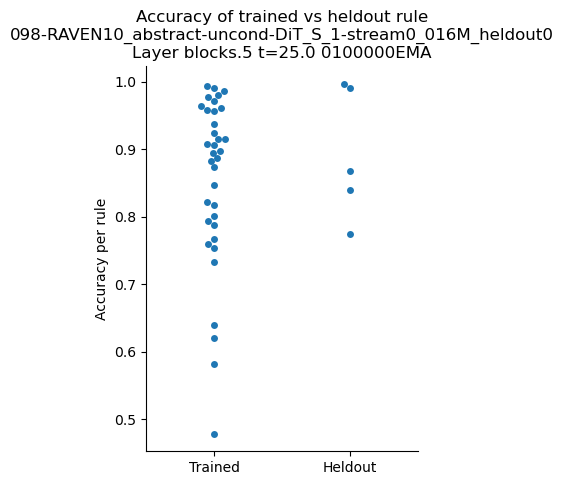

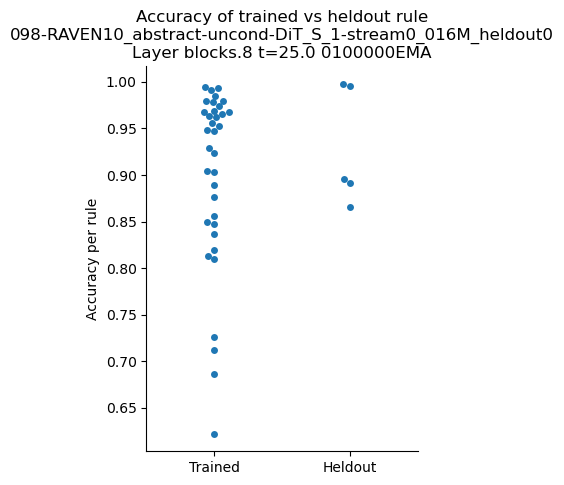

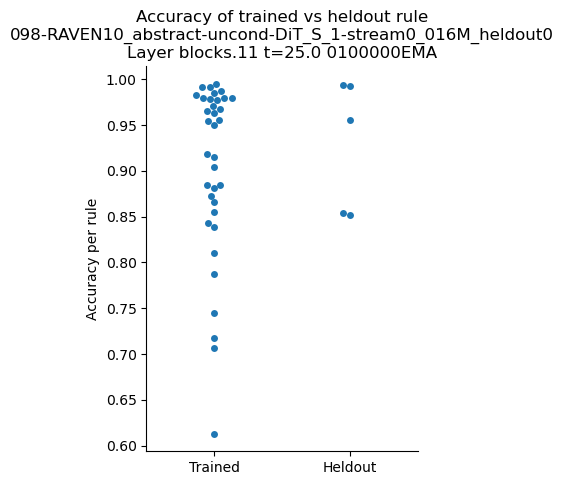

In [41]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_rules] = True
epoch = 100000
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt{epoch:07d}EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        
        acc_per_rule = np.diag(cm) / 1000
        plotdf = pd.DataFrame({"Rule": np.arange(40), "Accuracy": acc_per_rule, "Heldout": heldout_mask})
        figh = plt.figure(figsize=(3.5, 5))
        sns.swarmplot(data=plotdf, x="Heldout", y="Accuracy", dodge=True)
        plt.ylabel("Accuracy per rule")
        plt.xticks([0, 1], ["Trained", "Heldout"])
        plt.xlabel("")
        plt.title(f"Accuracy of trained vs heldout rule\n{expname_short}\nLayer {layer} t={t_scalar} {epoch:07d}EMA")
        figh.show()
        # fig1, fig2 = visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"{expname}\nckpt 1000000EMA Layer {layer} t={t_scalar}")
        saveallforms(figexpdir, f"acc_per_rule_train_vs_heldout_{layer}_t{t_scalar}_ckpt{epoch:07d}EMA", figh)

In [42]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_rules] = True
epoch = 100000
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt{epoch:07d}EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        
        print(f"Layer {layer} t={t_scalar} {epoch:07d}MA")
        acc_per_rule = np.diag(cm) / 1000
        plotdf = pd.DataFrame({"Rule": np.arange(40), "Accuracy": acc_per_rule, "Heldout": heldout_mask})
        print(plotdf.groupby("Heldout").agg({"Accuracy": ["mean", "std"]}))

Layer blocks.0 t=25.0 0100000MA
         Accuracy          
             mean       std
Heldout                    
False    0.311371  0.212003
True     0.492000  0.300647
Layer blocks.2 t=25.0 0100000MA
         Accuracy          
             mean       std
Heldout                    
False    0.590943  0.193436
True     0.708200  0.272977
Layer blocks.5 t=25.0 0100000MA
         Accuracy          
             mean       std
Heldout                    
False    0.853829  0.126824
True     0.893600  0.097300
Layer blocks.8 t=25.0 0100000MA
        Accuracy          
            mean       std
Heldout                   
False     0.8994  0.096822
True      0.9294  0.062752
Layer blocks.11 t=25.0 0100000MA
         Accuracy          
             mean       std
Heldout                    
False    0.902743  0.096161
True     0.929800  0.071765


In [43]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_rules] = True
logic_mask = np.arange(40) % 10 > 6
logic_mask[30:] = False
epoch = 100000
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt{epoch:07d}EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        acc_per_rule = np.diag(cm) / 1000
        print(f"Layer {layer} t={t_scalar} {epoch:07d}EMA")
        plotdf = pd.DataFrame({"Rule": np.arange(40), "Accuracy": acc_per_rule, "Heldout": heldout_mask, "Logic_attr": logic_mask})
        print(plotdf.groupby("Logic_attr").agg({"Accuracy": ["mean", "std"]}))

Layer blocks.0 t=25.0 0100000EMA
            Accuracy          
                mean       std
Logic_attr                    
False       0.378516  0.228974
True        0.180444  0.152442
Layer blocks.2 t=25.0 0100000EMA
            Accuracy          
                mean       std
Logic_attr                    
False       0.636000  0.200518
True        0.500889  0.192632
Layer blocks.5 t=25.0 0100000EMA
            Accuracy          
                mean       std
Logic_attr                    
False       0.901935  0.078194
True        0.710222  0.137780
Layer blocks.8 t=25.0 0100000EMA
            Accuracy          
                mean       std
Logic_attr                    
False       0.939194  0.053326
True        0.779000  0.096255
Layer blocks.11 t=25.0 0100000EMA
            Accuracy          
                mean       std
Logic_attr                    
False       0.942645  0.052847
True        0.780333  0.093979


In [44]:
heldout_mask = np.zeros(40, dtype=bool)
heldout_mask[heldout_rules] = True
logic_mask = np.arange(40) % 10 > 6
logic_mask[30:] = False
epoch = 100000
df_col = []
for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt{epoch:07d}EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        acc_per_rule = np.diag(cm) / 1000
        plotdf = pd.DataFrame({"Rule": np.arange(40), "Accuracy": acc_per_rule, "Heldout": heldout_mask, "Logic_attr": logic_mask, "Layer": layer})
        # print(f"Layer {layer} t={t_scalar} 1000000EMA")
        # print(plotdf.groupby("Logic_attr").agg({"Accuracy": ["mean", "std"]}))
        df_col.append(plotdf)
df_all = pd.concat(df_col, axis=0)

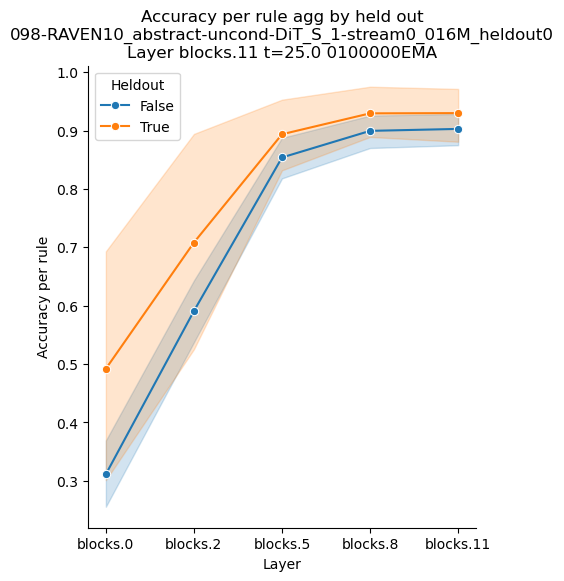

In [45]:
plt.figure(figsize=(5, 6))
sns.lineplot(data=df_all, x="Layer", y="Accuracy", hue="Heldout", marker="o", estimator=np.mean, errorbar=('ci', 90))
plt.ylabel("Accuracy per rule")
plt.xlabel("Layer")
plt.title(f"Accuracy per rule agg by held out\n{expname_short}\nLayer {layer} t={t_scalar} {epoch:07d}EMA")
saveallforms(figexpdir, f"acc_per_rule_class_agg_heldout_{layer}_t{t_scalar}_ckpt{epoch:07d}EMA", plt.gcf())

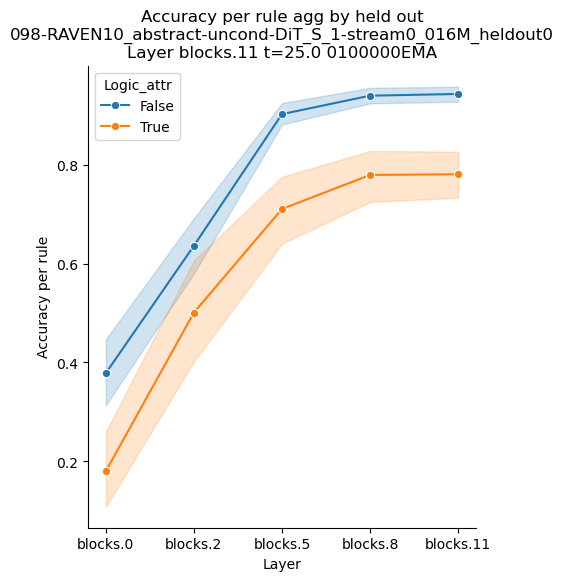

In [46]:
plt.figure(figsize=(5, 6))
sns.lineplot(data=df_all, x="Layer", y="Accuracy", hue="Logic_attr", marker="o", estimator=np.mean, errorbar=('ci', 90))
plt.ylabel("Accuracy per rule")
plt.xlabel("Layer")
plt.title(f"Accuracy per rule agg by held out\n{expname_short}\nLayer {layer} t={t_scalar} {epoch:07d}EMA")
saveallforms(figexpdir, f"acc_per_rule_class_agg_logic_attr_{layer}_t{t_scalar}_ckpt{epoch:07d}EMA", plt.gcf())

## Representation and UMap 

In [40]:
from repr_probe_lib import extract_features_DiT, train_pca_sgd_classifiers
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [42]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

torch.Size([120000, 3, 9, 9]) torch.Size([120000])


In [43]:
sys.path.append("/n/home12/binxuwang/Github/DiT")
from diffusion import create_diffusion
from models import DiT


In [44]:
DiT_configs = {
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}
device = "cuda"
class_dropout_prob = 1.0
num_classes = 0
model_cfg = DiT_configs["DiT_S_1"]
model_DiT = DiT(input_size=9,
            in_channels=3, **model_cfg,
            mlp_ratio=4.0,
            class_dropout_prob=class_dropout_prob,
            num_classes=num_classes,
            learn_sigma=True,)

In [45]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
ckpt_path = join(ckptdir, "1000000.pt")
state_dict = th.load(ckpt_path, )
model_DiT.load_state_dict(state_dict["ema"])
model_DiT.to(device).eval();

In [46]:
# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to(device)
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to(device)

In [47]:
t_scalar = 25
fetcher = featureFetcher_module()
for i in (5, 8, 11):#range(len(model.blocks)):
    fetcher.record_module(model_DiT.blocks[i], target_name=f"blocks{i}")
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
feature_col = extract_features_DiT(model_DiT, fetcher, train_loader, dataset_Xmean, dataset_Xstd, t_scalar)
feature_col_test = extract_features_DiT(model_DiT, fetcher, test_loader, dataset_Xmean, dataset_Xstd, t_scalar)

  0%|          | 0/59 [00:00<?, ?it/s]

blocks5: torch.Size([120000, 81, 384])
blocks8: torch.Size([120000, 81, 384])
blocks11: torch.Size([120000, 81, 384])


  0%|          | 0/20 [00:00<?, ?it/s]

blocks5: torch.Size([40000, 81, 384])
blocks8: torch.Size([40000, 81, 384])
blocks11: torch.Size([40000, 81, 384])


In [48]:
feature_avg_col = {k: v.mean(dim=1) for k, v in feature_col.items()}
feature_avg_col_test = {k: v.mean(dim=1) for k, v in feature_col_test.items()}
feature_last_col = {k: v[:, -1] for k, v in feature_col.items()}
feature_last_col_test = {k: v[:, -1] for k, v in feature_col_test.items()}

### UMap

In [73]:
from rule_new_utils import relation_dict_brief, attribute_dict, rule_table_brief, rule_table
from matplotlib.colors import ListedColormap
# Define a discrete colormap
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])

In [ ]:
import colorsys

def generate_color_grid(rows=4, columns=10):
    color_grid = []
    # Define hue progression: evenly spaced around the color wheel
    hue_step = 1.0 / columns  # colorsys hue is between 0 and 1
    hues = [i * hue_step for i in range(columns)]
    # Define saturation and lightness for each row to ensure dissimilarity
    # You can adjust these values to tweak the appearance
    row_settings = [
        {'saturation': 0.9, 'lightness': 0.5},  # Row 1: Vibrant colors
        {'saturation': 0.6, 'lightness': 0.4},  # Row 2: Subdued tones
        {'saturation': 0.9, 'lightness': 0.7},  # Row 3: Bright, vivid colors
        {'saturation': 0.4, 'lightness': 0.3},  # Row 4: Muted, darker shades
    ]
    
    for row in range(rows):
        settings = row_settings[row]
        for col in range(columns):
            hue = hues[col]
            saturation = settings['saturation']
            lightness = settings['lightness']
            
            # Convert HSL to RGB
            r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
            
            # Convert RGB from [0,1] to [0,255] and then to HEX
            r_hex = int(r * 255)
            g_hex = int(g * 255)
            b_hex = int(b * 255)
            hex_color = f'#{r_hex:02X}{g_hex:02X}{b_hex:02X}'
            
            color_grid.append(hex_color)
    
    return color_grid

# Generate the color grid
colors_40 = generate_color_grid()

# Display the colors in a 4x10 grid format
for row in range(4):
    row_colors = colors_40[row*10:(row+1)*10]
    print(f"Row {row+1}: {', '.join(row_colors)}")

Row 1: #F20C0C, #F2960C, #C4F20C, #3AF20C, #0CF268, #0CF2F2, #0C68F2, #3A0CF2, #C40CF2, #F20C96
Row 2: #A32828, #A37228, #8AA328, #41A328, #28A359, #28A3A3, #2859A3, #4128A3, #8A28A3, #A32872
Row 3: #F76D6D, #F7C06D, #DBF76D, #89F76D, #6DF7A4, #6DF7F7, #6DA4F7, #896DF7, #DB6DF7, #F76DC0
Row 4: #6B2D2D, #6B522D, #5E6B2D, #3A6B2D, #2D6B46, #2D6B6B, #2D466B, #3A2D6B, #5E2D6B, #6B2D52


In [52]:
import umap
import matplotlib.pyplot as plt
# Assuming features is your feature matrix and labels is your label array
reducer = umap.UMAP(transform_seed=43)
embedding = reducer.fit_transform(feature_avg_col_test["blocks11"])

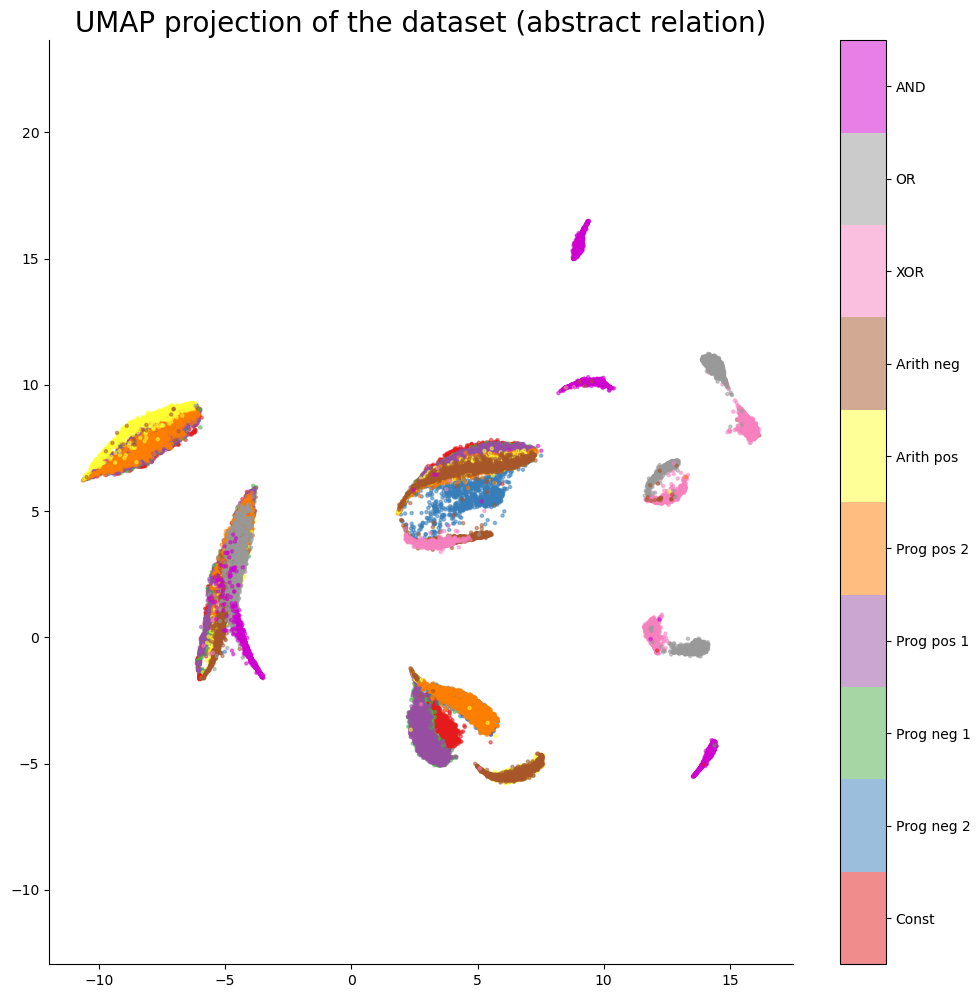

In [114]:
rela_test = (y_test % 10) 
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=rela_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([relation_dict_brief[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);
saveallforms(figexpdir, f"UMAP_relation_color_blocks11_t{t_scalar}_ckpt1000000EMA", )

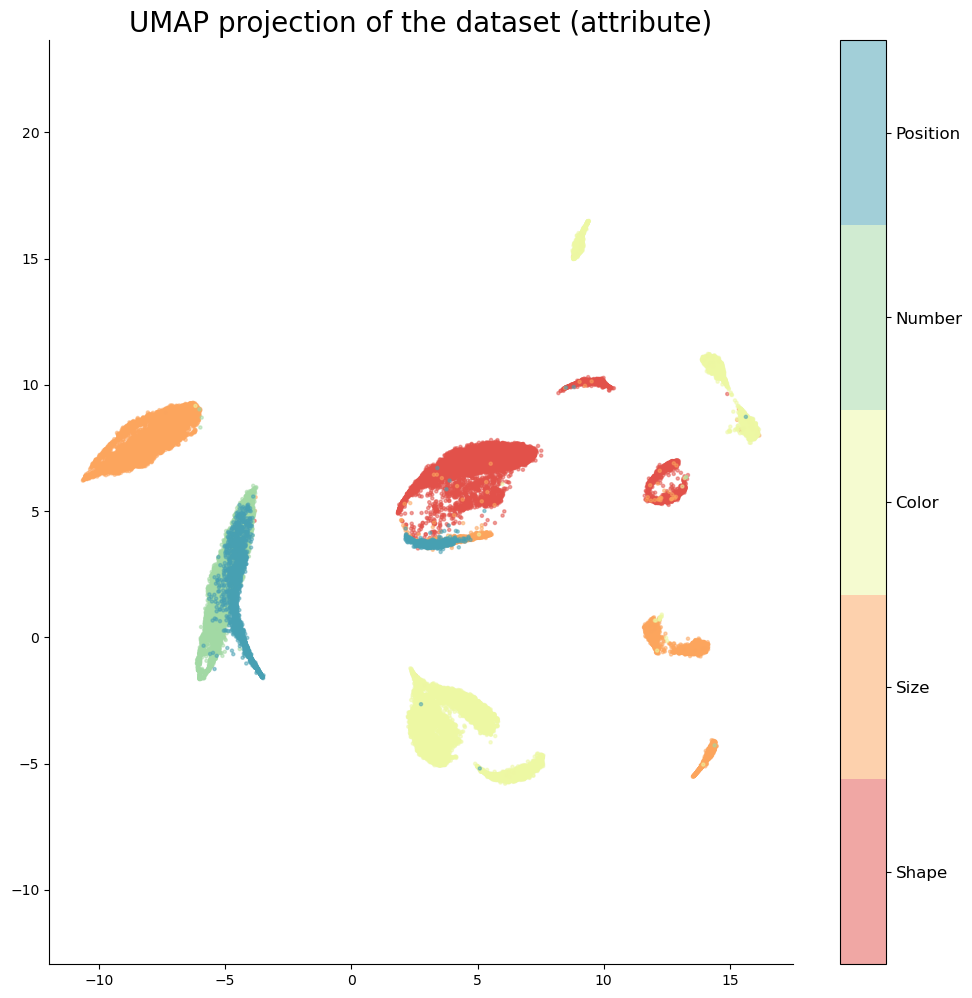

In [115]:
attr_test = (y_test//10) + (y_test > 36).int()
cmap = ListedColormap(sns.color_palette("Spectral", 6))
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=attr_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(6)-0.5)
cb.set_ticks(np.arange(5),)#["shape","size","color","number","position"])
cb.set_ticklabels([attribute_dict[i] for i in range(5)], fontsize=12)
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);
saveallforms(figexpdir, f"UMAP_attr_color_blocks11_t{t_scalar}_ckpt1000000EMA", )

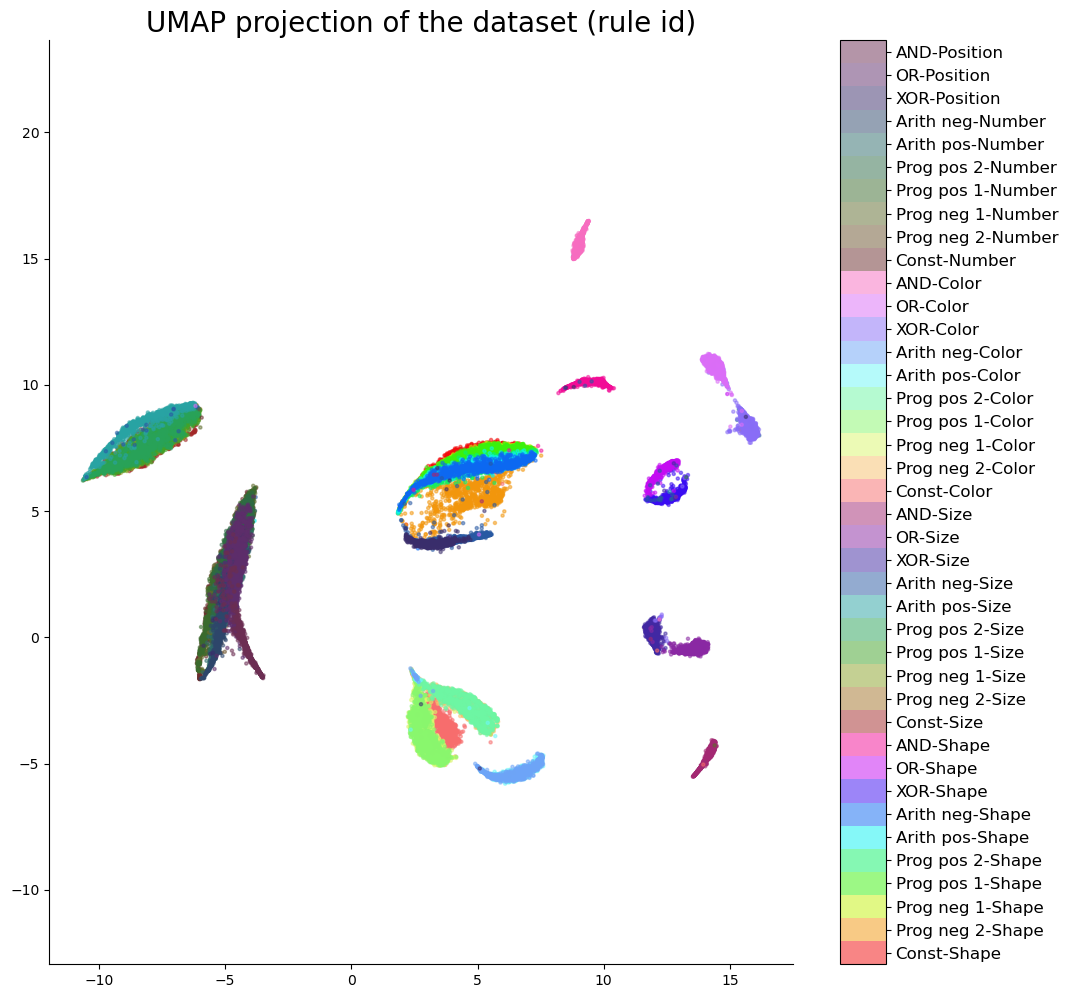

In [116]:
cmap = ListedColormap(colors_40)
plt.figure(figsize=(12, 12))
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(41)-0.5)
cb.set_ticks(np.arange(40),)#["shape","size","color","number","position"])
cb.set_ticklabels([rule_table_brief[i] for i in range(40)], fontsize=12)
plt.title('UMAP projection of the dataset (rule id)', fontsize=20);
saveallforms(figexpdir, f"UMAP_rule_color_blocks11_t{t_scalar}_ckpt1000000EMA", )

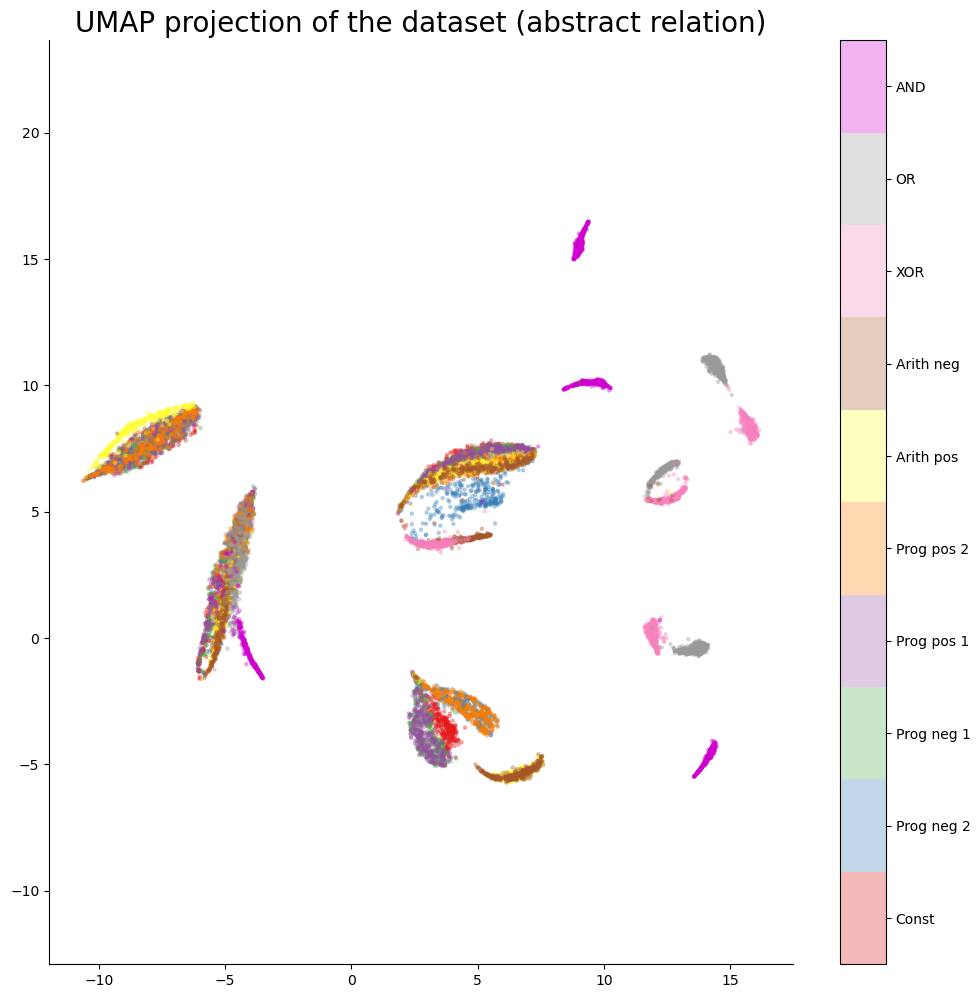

In [120]:
rela_test = (y_test % 10) 
cmap = ListedColormap(['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#d000d0'])
plt.figure(figsize=(12, 12))
plt.scatter(embedding[::3, 0], embedding[::3, 1], c=rela_test[::3], cmap=cmap, s=5, alpha=0.3)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(11)-0.5)
cb.set_ticks(np.arange(10))#boundaries=np.arange(41)-0.5).set_ticks(np.arange(40))
cb.set_ticklabels([relation_dict_brief[i] for i in range(10)])
plt.title('UMAP projection of the dataset (abstract relation)', fontsize=20);
saveallforms(figexpdir, f"UMAP_relation_color_blocks11_t{t_scalar}_ckpt1000000EMA_sparse", )

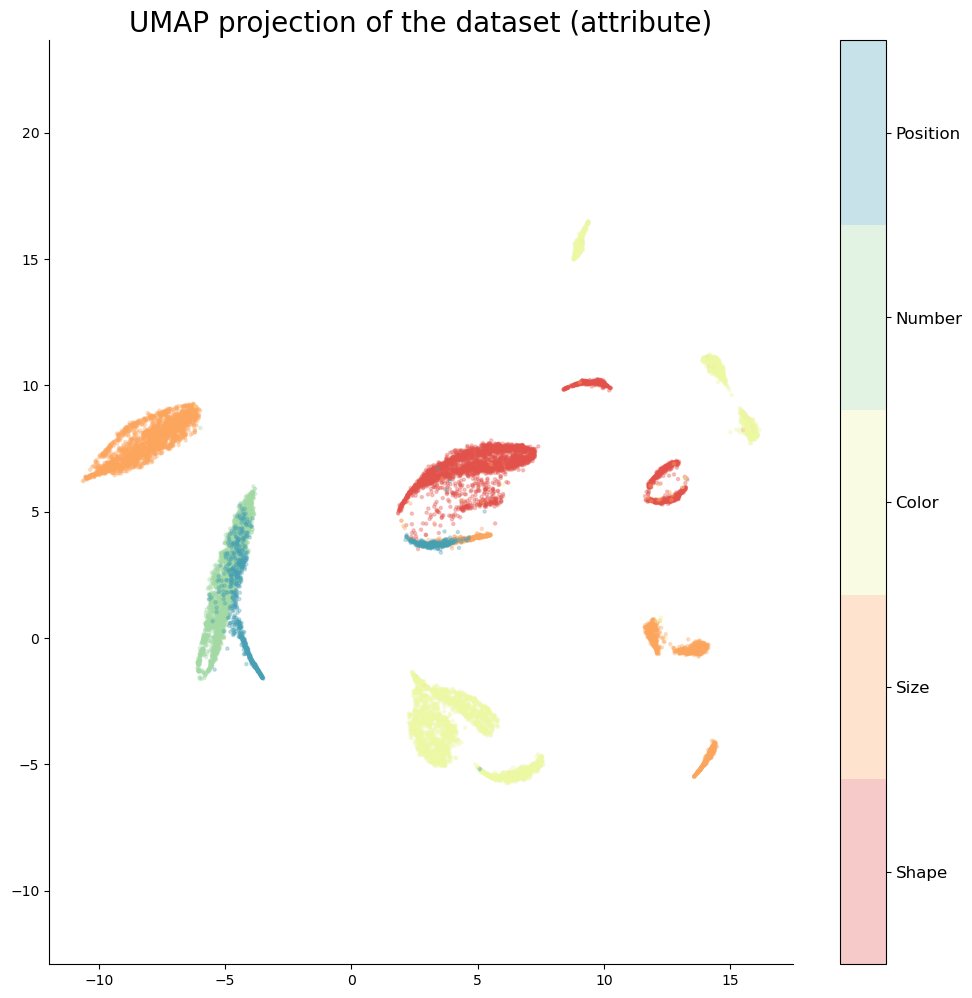

In [121]:
attr_test = (y_test//10) + (y_test > 36).int()
cmap = ListedColormap(sns.color_palette("Spectral", 6))
plt.figure(figsize=(12, 12))
plt.scatter(embedding[::3, 0], embedding[::3, 1], c=attr_test[::3], cmap=cmap, s=5, alpha=0.3)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(6)-0.5)
cb.set_ticks(np.arange(5),)#["shape","size","color","number","position"])
cb.set_ticklabels([attribute_dict[i] for i in range(5)], fontsize=12)
plt.title('UMAP projection of the dataset (attribute)', fontsize=20);
saveallforms(figexpdir, f"UMAP_attr_color_blocks11_t{t_scalar}_ckpt1000000EMA_sparse", )

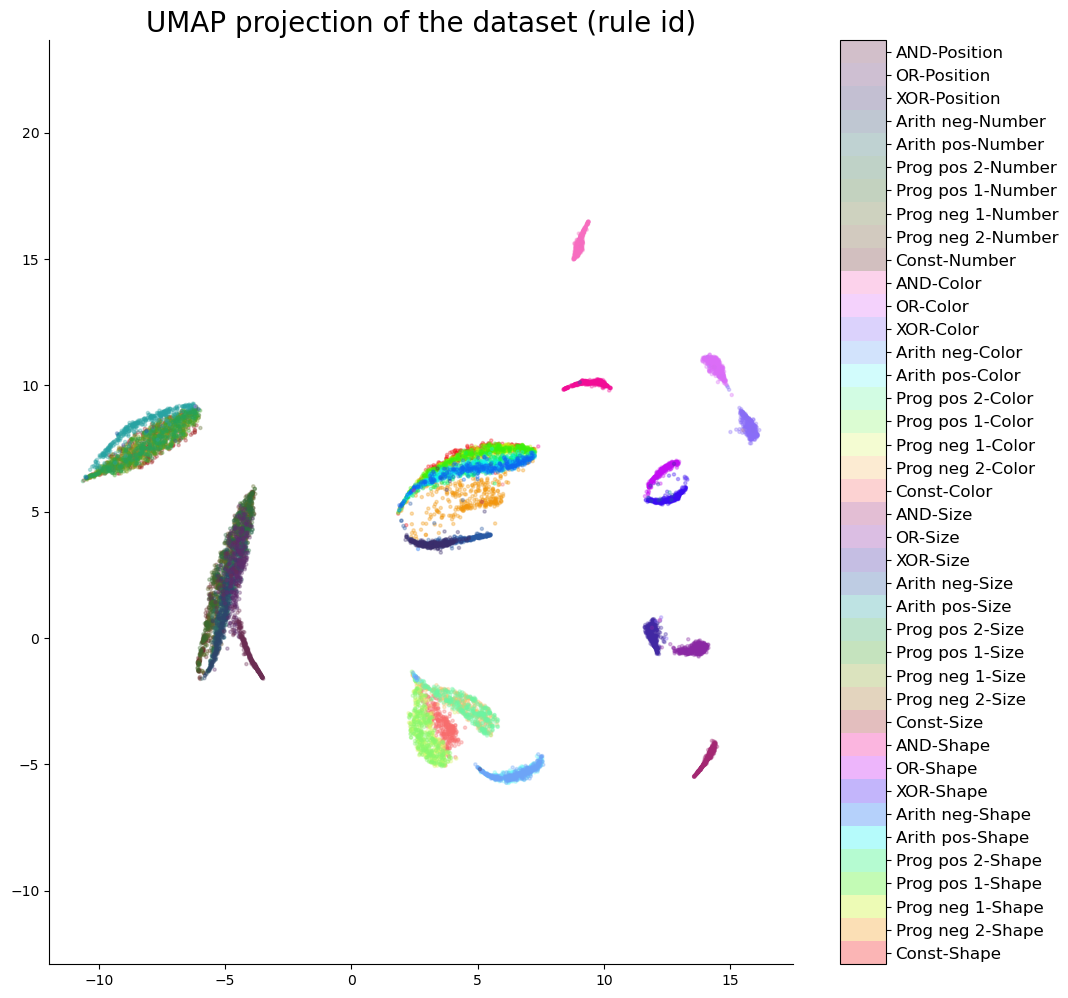

In [122]:
cmap = ListedColormap(colors_40)
plt.figure(figsize=(12, 12))
plt.scatter(embedding[::3, 0], embedding[::3, 1], c=y_test[::3], cmap=cmap, s=5, alpha=0.3)
# plt.scatter(embedding[:, 0], embedding[:, 1], c=y_test, cmap=cmap, s=5, alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
cb = plt.colorbar(boundaries=np.arange(41)-0.5)
cb.set_ticks(np.arange(40),)#["shape","size","color","number","position"])
cb.set_ticklabels([rule_table_brief[i] for i in range(40)], fontsize=12)
plt.title('UMAP projection of the dataset (rule id)', fontsize=20);
saveallforms(figexpdir, f"UMAP_rule_color_blocks11_t{t_scalar}_ckpt1000000EMA_sparse", )

### RDM

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
layername = "blocks11"#"dec.1x1_in1"#"dec.3x3_up";#"dec.1x1_in1" # "enc.1x1_down"
# Compute the cosine similarity matrix
featmatr = feature_avg_col_test[layername].flatten(start_dim=1)#.squeeze()
feat_shape = feature_avg_col_test[layername].shape[1:]
feat_mean = featmatr.mean(dim=0)
feat_cent = featmatr - feat_mean[None, :]
featmat_sparse = feat_cent[::5,:]
cosine_sim_matrix = cosine_similarity(featmat_sparse)
# print(cosine_sim_matrix)
n = cosine_sim_matrix.shape[0]
reshaped = cosine_sim_matrix.reshape(40, n//40, 40, n//40)
coarse_grained_matrix = reshaped.mean(axis=(1, 3))

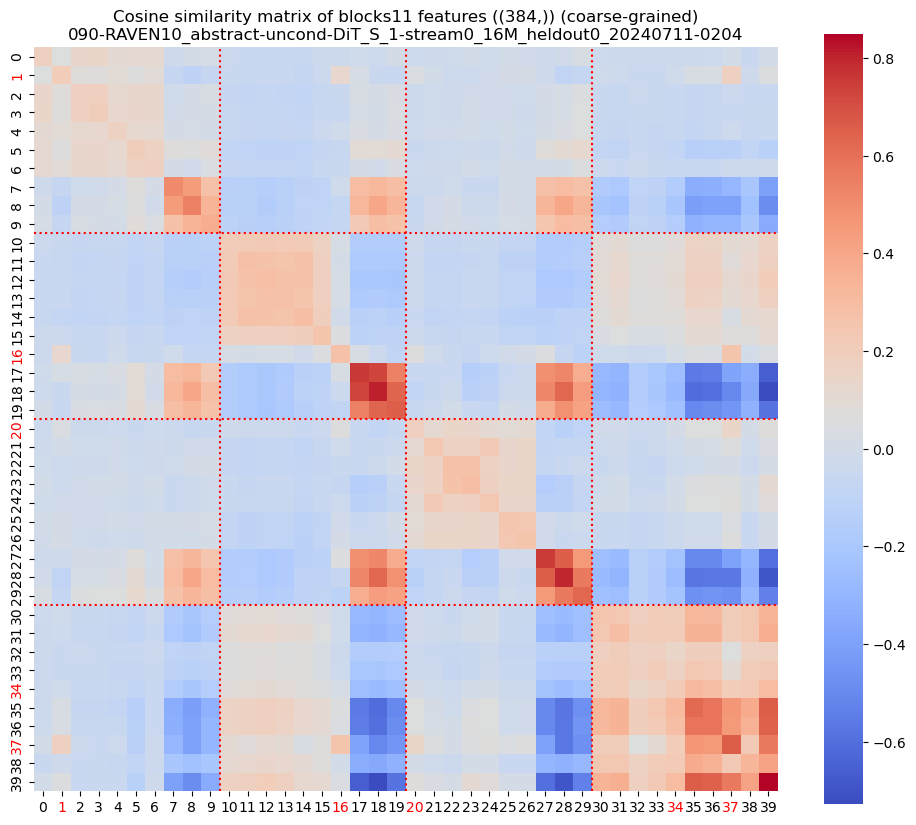

In [113]:
heldout_ids = heldout_rules
plt.figure(figsize=(12,10))
sns.heatmap(coarse_grained_matrix, annot=False, cmap='coolwarm', 
            xticklabels=True, yticklabels=True)
for sep in [10,20,30]:
    plt.axhline(sep, color="r", linestyle=":")
    plt.axvline(sep, color="r", linestyle=":")
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
for i, xtick in enumerate(xticks):
    if i in heldout_ids:  # Change color of every 10th xtick label
        xtick.set_color('red')
for i, ytick in enumerate(yticks):
    if i in heldout_ids:  # Change color of every 10th ytick label
        ytick.set_color('red')
plt.axis("image")
plt.title(f"Cosine similarity matrix of {layername} features ({tuple(feat_shape)}) (coarse-grained)\n{expname}") #  (red=held-out)
saveallforms(figexpdir, f"cosine_sim_{layername}_t{t_str}_ckpt1000000EMA", )
plt.show()

### PCA

In [102]:
def compute_pca(featmatr, n_components=None):
    """
    Compute PCA on the given feature matrix.

    Args:
        featmatr (torch.Tensor): The input feature matrix of shape (n_samples, n_features).
        n_components (int, optional): Number of principal components to retain. 
                                      If None, all components are retained.

    Returns:
        principal_components (torch.Tensor): Principal components (eigenvectors) of shape (n_features, n_components).
        explained_variance (torch.Tensor): Explained variance (eigenvalues) of shape (n_components,).
        feat_mean (torch.Tensor): Mean of the features, shape (n_features,).
    """
    # Ensure featmatr is a float tensor
    if not featmatr.is_floating_point():
        featmatr = featmatr.float()
    # Step 1: Compute the mean of each feature
    feat_mean = featmatr.mean(dim=0)
    # Step 2: Center the data by subtracting the mean
    feat_cent = featmatr - feat_mean[None, :]  # Shape: (n_samples, n_features)
    # Step 3: Compute the covariance matrix
    # Covariance matrix shape: (n_features, n_features)
    cov = torch.matmul(feat_cent.T, feat_cent) / (feat_cent.size(0) - 1)
    # Step 4: Perform eigen decomposition on the covariance matrix
    # torch.linalg.eigh returns eigenvalues in ascending order
    eigenvalues, eigenvectors = torch.linalg.eigh(cov)
    # Step 5: Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # Step 6: Select the top n_components if specified
    if n_components is not None:
        eigenvalues = eigenvalues[:n_components]
        eigenvectors = eigenvectors[:, :n_components]
    
    proj_feat = torch.matmul(feat_cent, eigenvectors)
    
    # Step 7: Return the principal components, explained variance, and feature mean
    return eigenvectors, eigenvalues, feat_mean, proj_feat


# compute the number of components to retain for k% variance
def compute_n_components(eigenvalues, variance_retained=0.95):
    """
    Compute the number of principal components to retain to explain a certain percentage of variance.

    Args:
        eigenvalues (torch.Tensor): Eigenvalues of the covariance matrix in descending order.
        variance_retained (float): The percentage of variance to retain.

    Returns:
        n_components (int): Number of principal components to retain.
    """
    # Compute the total variance
    total_variance = eigenvalues.sum()
    # Compute the explained variance ratio
    explained_variance_ratio = eigenvalues / total_variance
    # Find the number of components to retain
    cumulative_variance_ratio = explained_variance_ratio.cumsum(dim=0)
    n_components = (cumulative_variance_ratio < variance_retained).sum().item()
    return n_components


In [103]:
eigvec, eigval, featmean, proj_feat = compute_pca(featmatr.cuda(), n_components=None)

In [100]:
print("N components for 90% variance: ", compute_n_components(eigval, variance_retained=0.90))
print("N components for 95% variance: ", compute_n_components(eigval, variance_retained=0.95))
print("N components for 99% variance: ", compute_n_components(eigval, variance_retained=0.99))

N components for 90% variance:  29
N components for 95% variance:  49
N components for 99% variance:  145


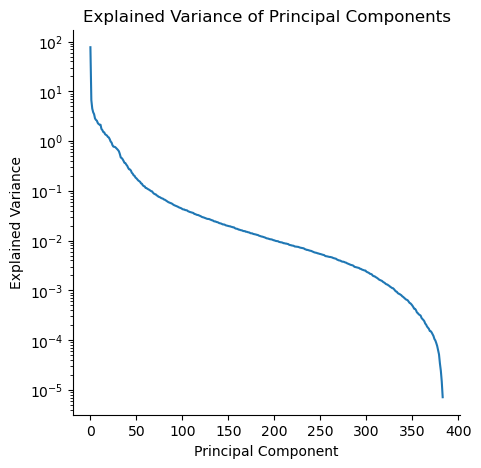

In [112]:
plt.figure(figsize=(5, 5))
plt.plot(eigval.cpu().numpy())
plt.yscale("log")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance of Principal Components")
plt.show()

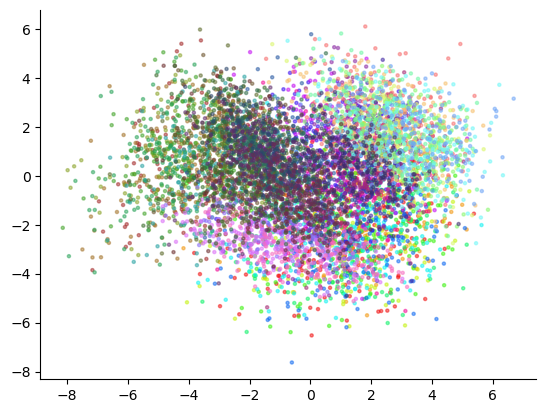

In [111]:
proj_feat = proj_feat.cpu()
plt.scatter(proj_feat[::5, 1], proj_feat[::5, 2], c=y_test[::5], cmap=cmap, s=5, alpha=0.5)#

### Collapsed run

## Old code scratch

### Synthesize Classification accuracy across time

In [11]:
syn_df_all = []
t_scalar = 0.1
for PCdim in [1024, ]:
    for t_scalar in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        t_str = str(t_scalar).replace(".", "_")
        results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["t"] = t_scalar
        syn_df["PCdim"] = PCdim
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

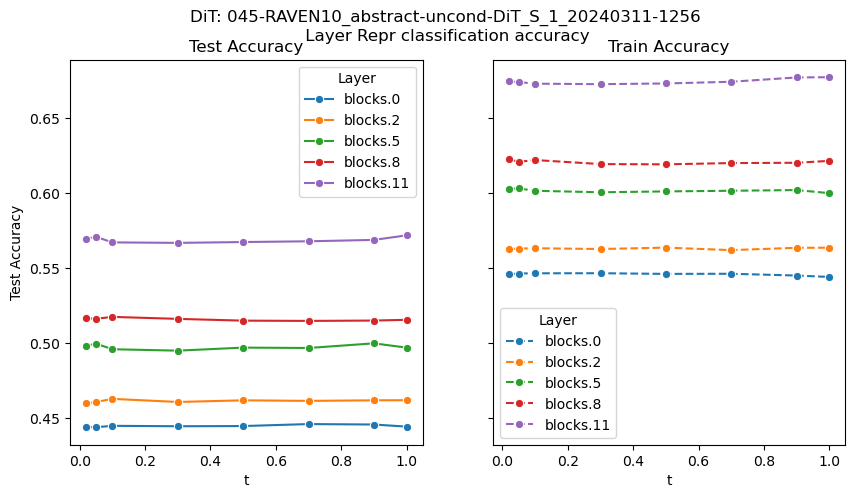

In [12]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="t", y="Test Accuracy", hue="Layer", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="t", y="Train Accuracy", hue="Layer", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

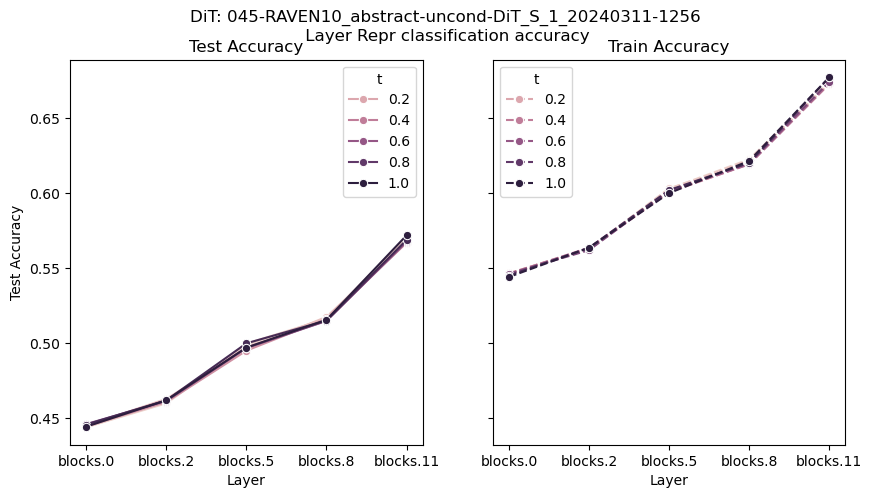

In [13]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all, x="Layer", y="Test Accuracy", hue="t", marker="o")
plt.title(f"Test Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all, x="Layer", y="Train Accuracy", hue="t", marker="o", linestyle="--")
plt.title(f"Train Accuracy")
plt.suptitle(f"DiT: {expname}\n Layer Repr classification accuracy")
plt.show()

In [46]:
for t in [0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    syn_df = syn_df_all[syn_df_all["t"]==t]
    print(f"t={t}")
    print(syn_df)

t=0.02
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444175        0.545925  0.02
1   blocks.2       0.460025        0.562658  0.02
2   blocks.5       0.498350        0.602717  0.02
3   blocks.8       0.516600        0.622467  0.02
4  blocks.11       0.569600        0.674267  0.02
t=0.05
       Layer  Test Accuracy  Train Accuracy     t
0   blocks.0       0.444125        0.546400  0.05
1   blocks.2       0.460900        0.563008  0.05
2   blocks.5       0.499700        0.603025  0.05
3   blocks.8       0.516300        0.620725  0.05
4  blocks.11       0.570775        0.673783  0.05
t=0.1
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.445050        0.546550  0.1
1   blocks.2       0.463000        0.563225  0.1
2   blocks.5       0.496025        0.601467  0.1
3   blocks.8       0.517550        0.621917  0.1
4  blocks.11       0.567125        0.672733  0.1
t=0.3
       Layer  Test Accuracy  Train Accuracy    t
0   blocks.0       0.444775    

### Synthesize Classification accuracy through the training process

In [48]:
!cd {exproot}; ls -d 075*

075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243


In [15]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"075-RAVEN10_abstract-uncond-DiT_S_1_20240401-0243"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
# ckpt_path = join(ckptdir, "1000000.pt")
# state_dict = th.load(ckpt_path, )
# model.load_state_dict(state_dict["model"])
# model.to("cuda").eval();

In [16]:
syn_df_all = []
t_scalar = 0.1
t_str = str(t_scalar).replace(".", "_")
PCdim = 1024
for PCdim in [1024, "FULL"]:
    for epoch in [0,20000, 100000, 200000, 500000, 1000000]:
        if epoch == 0:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}ckptRNDINIT.pkl"), "rb"))
        else:
            results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_PC{PCdim}ckpt{epoch:07d}.pkl"), "rb"))
        test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
        train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
        syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
        syn_df.columns = ["Test Accuracy", "Train Accuracy"]
        syn_df["epoch"] = epoch
        syn_df["PCdim"] = PCdim
        # drop index as layer name
        syn_df = syn_df.reset_index()
        syn_df = syn_df.rename(columns={"index": "Layer"})
        syn_df_all.append(syn_df)
    
syn_df_all = pd.concat(syn_df_all, axis=0)

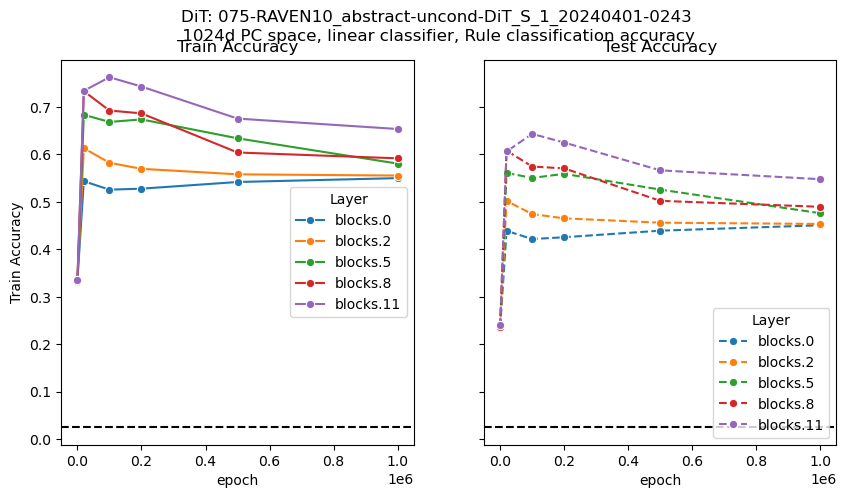

In [17]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Train Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Test Accuracy")
plt.suptitle(f"DiT: {expname}\n 1024d PC space, linear classifier, Rule classification accuracy")
plt.show()

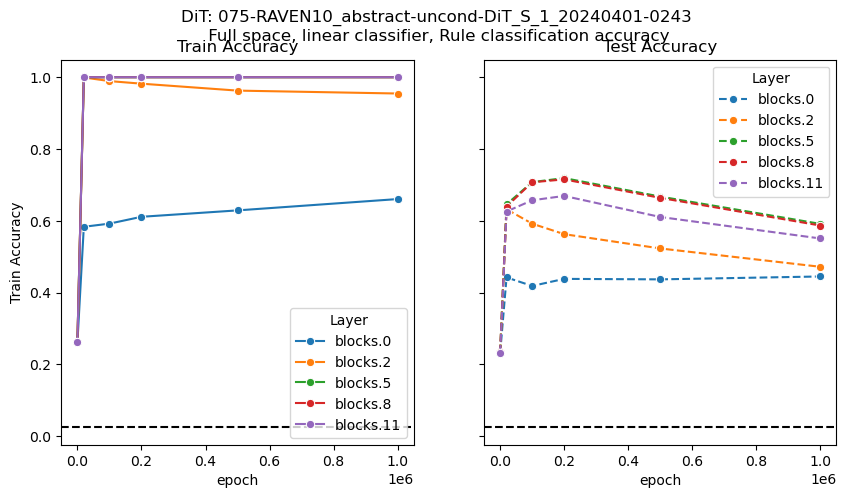

In [18]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Train Accuracy")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--")
plt.title(f"Test Accuracy")
plt.suptitle(f"DiT: {expname}\n Full space, linear classifier, Rule classification accuracy")
plt.show()

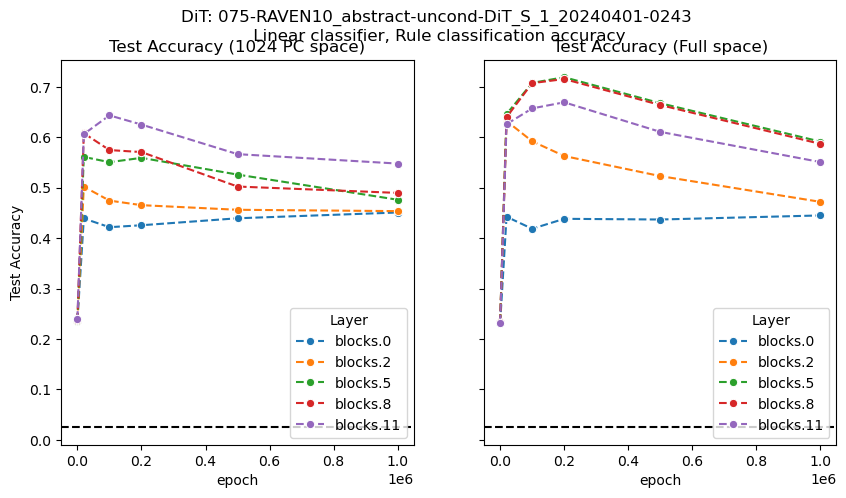

In [19]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
# sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Train Accuracy", hue="Layer", marker="o")
# sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Train Accuracy", hue="Layer", marker="+")
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (1024 PC space)")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="epoch", y="Test Accuracy", hue="Layer", marker="o", linestyle="--")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (Full space)")
plt.suptitle(f"DiT: {expname}\n Linear classifier, Rule classification accuracy")
plt.show()

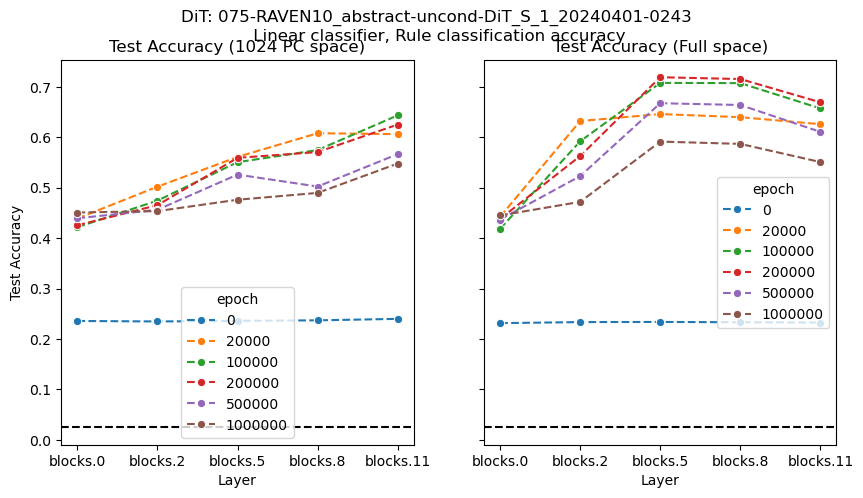

In [21]:
plt.subplots(1, 2, figsize=(10,5), sharey=True)
plt.subplot(1,2,1)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim==1024], x="Layer", y="Test Accuracy", hue="epoch", marker="o", linestyle="--", palette="tab10")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (1024 PC space)")
plt.subplot(1,2,2)
sns.lineplot(data=syn_df_all[syn_df_all.PCdim=="FULL"], x="Layer", y="Test Accuracy", hue="epoch", marker="o", linestyle="--", palette="tab10")
plt.axhline(1/40, color="black", linestyle="--", label="Chance level")
plt.title(f"Test Accuracy (Full space)")
plt.suptitle(f"DiT: {expname}\n Linear classifier, Rule classification accuracy")
plt.show()